In [12]:
import json
import os
import psutil
import time
import warnings
import sys
from math import ceil, fsum
import numpy as np
import numba as nb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from scipy import interpolate
from scipy.signal import find_peaks
from scipy.integrate import quad, simpson, trapezoid, IntegrationWarning
from scipy.optimize import curve_fit, minimize, differential_evolution, brentq, NonlinearConstraint, least_squares
from scipy.stats import cauchy, chi2
from scipy.signal import butter, filtfilt
from scipy.special import huber

from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.utils import resample

from skopt import gp_minimize
from skopt.space import Real

from tqdm.notebook import tqdm, trange
from tqdm.contrib import tenumerate

import joblib
from joblib import Parallel, delayed, parallel_backend

from itertools import product, combinations
import multiprocessing

# Bootstrapping functionality
import random
from typing import Dict, List, Tuple, Set

from package import filter_function as ff
from package import noise_spectra as ns
from package import coherence_profile as cp
from package.noise_learning_fitting import func_to_fit, fit_coherence_decay, fit_noise_spectrum
from package.fitting_utils import find_widest_contiguous_stretch


# Fitting S(ω) to Experimental C(t) data

Let's Examine how to fit experimental C(t) data to a given noise model. First, we will load some example experimental data from `data/example_XY8data_normtotpi1.json`

N = 1.0 C(t) std = 0.10101004001349595
12 25


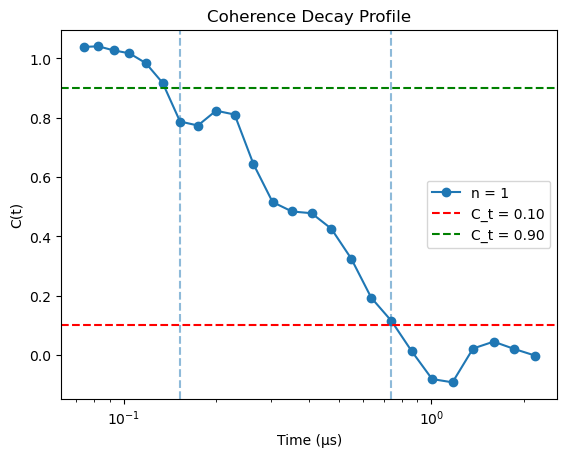

N = 8 C(t) std = 0.08911570323059104
21 70


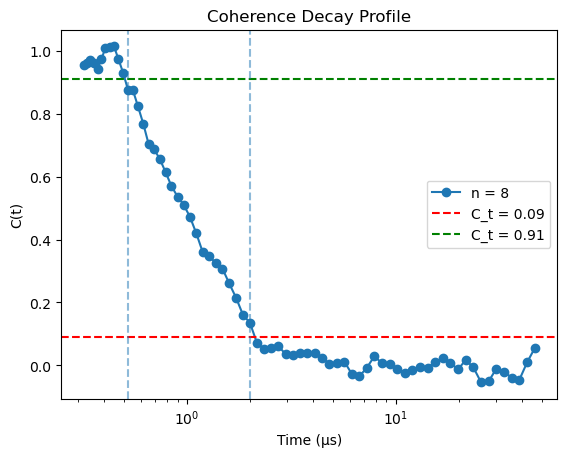

N = 128 C(t) std = 0.1350859853788234
6 35


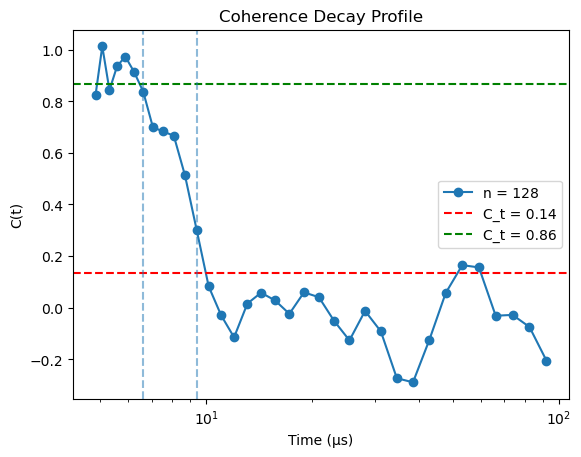

N = 256 C(t) std = 0.1290418560176288
7 26


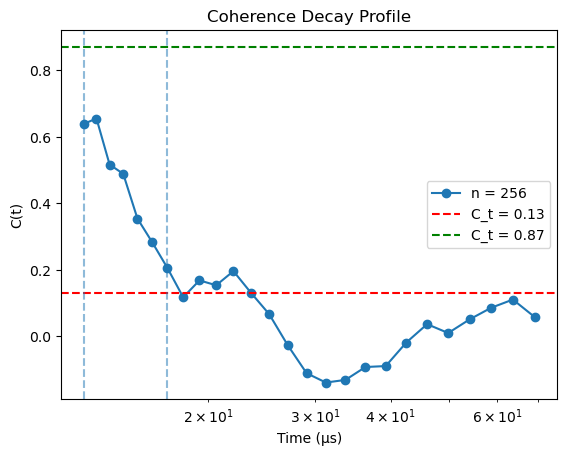

N = 512 C(t) std = 0.23271598441478955
5 11


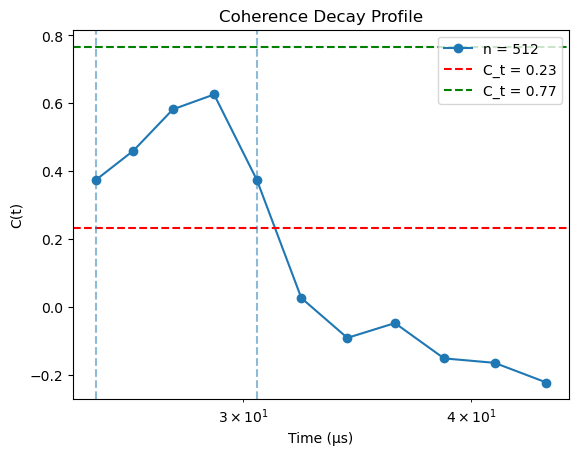

In [ ]:
###### Check to see what time ranges we are using for the C(t) data. We want σ < C(t) < 1-σ, where σ is the standard deviation of the residual for the 1/f fit of the C(t) data.

### Total execution time for this cell on my laptop: 16s ###


# loads C(t) from data file, which is in the form of a dictionary with keys "N_pi", "time_points", and "C_t".
# with open("XY8data_forNoah.json","r") as file:
with open("data/example_XY8data_normtotpi1.json","r") as file:
    data = json.load(file)
# Re-format as a pandas dataframe for easier handling
del data["y_fit"]
df = pd.DataFrame(data)


##### 
# Hardcoded parameters for the FWFF and delta fits. These are found from the fits of the C(t) data to the power law function. We will show how to do
# this later in the tutorial. For now, these parameters will be used to find σ, so that we can show, σ < C(t) < 1-σ.
# #####

# For N in {1,8,128,256,512}, the parameters [A, alpha] for the 1/f noise spectrum S(ω) = A/ω^α
# These parameters are found from the fits of the C(t) data to this power law function
FWFF_params = {1: [24.53,0.73],
    8: [16.18,0.69],
    128: [143334052.69,5.2],
    256: [31.41,1.24],
    512: [118392.921361,3.386887]}

delta_params = {1: [31.20,0.82],
                8: [39.84,0.93],
                128: [128948015.786386,5.2],
                256: [477.36,1.98],
                512: [3960547.026715, 4.323269]}

########################################################

for n in data["N_pi"]:
    FWFF_dict = {
    "N1f": 1, # Number of 1/f noise parameters
    "Nlor": 0, # Number of Lorentzian noise parameters
    "NC": 0, # Number of white noise parameters
    "Ncf": 0, # Number of combined fraction noise parameters
    "N": int(n), #CPMG-N (test spin echo)
    "tau_p": 0.024, #pi pulse width in mircoseconds
    "integration_method": "trapezoid", # The method to use for integration. Options are "quad","trapezoid",and "simpson".
    "omega_resolution": int(10**5), # 6*10**5 The number of points to use when integrating to yield the coherence decay profile, C(t), unless method is "quad", in which case, this is the resolution used to determine the filter function and integrand outputs.
    "omega_range" : (10**(-4), 10**8), # The number of peaks to use in the filter function
    "num_peaks_cutoff": 100, # must be >=0 and <num_peaks. If this value is set, then only the top num_peaks_cutoff peaks will be used in the integration. This can be useful for speeding up the integration when the noise spectrum has many peaks.
    "peak_resolution": 100, # For every method except "quad", you can specify additional points around the singular points of the filter function. This argument specifies the number of points to use around each singular point.
    # "quad_limit": 10**5, # The maximum number of subdivisions in the adaptive quadrature algorithm
    # "epsabs": 1.49e-8, # Absolute tolerance for the quadrature integration
    # "epsrel": 1.49e-8, # Relative tolerance for the quadrature integration
    
    }

    n_df = df[df["N_pi"]==n]
    C_t_observed = np.array(n_df["C_t"].to_list()).flatten()
    t_points = (10**-3)*np.array(n_df["time_points"].to_list()).flatten() # multiply by 10**-3 to convert from nanoseconds to microseconds

    C_t_FWFF = func_to_fit(t_points, ns.noise_spectrum_1f, *FWFF_params[n], delta=False, **FWFF_dict) # computes C(t) from 1/f noise spectrum for the Filter-Width Filter Function (FWFF)
    # C_t_delta = func_to_fit(t_points, noise_spectrum_1f, *delta_params[n], delta=True, **FWFF_dict)
    sig = np.std(C_t_observed-C_t_FWFF) # computes sigma from C(t) residual
    print("N =", n, "C(t) std =", sig)
    # time_points = time_points[find_widest_contiguous_stretch(C_t_observed, sig, 1-sig)]
    # C_t_observed = C_t_observed[find_widest_contiguous_stretch(C_t_observed, sig, 1-sig)]

    # If you would instead like to see where C(t) is within some other parameter, x (i.e. x < C(t) < 1-x), then just set sig = x.
    emem = find_widest_contiguous_stretch(C_t_observed, sig, 1-sig) # computes indicies of the widest contiguous stretch of C(t) data that is within the bounds of sig and 1-sig

    print(len(emem),len(t_points))

    plt.plot(t_points,C_t_observed,label=f"n = {int(n)}",marker='o')
    # plt.axvline(x=n*0.024,linestyle='--',label=f"t = n*tau_pi= {n*0.024} µs", alpha=0.5)
    plt.axhline(y=sig, color='r', linestyle='--', label=f'C_t = {sig:.2f}')
    plt.axhline(y=1-sig, color='g', linestyle='--', label=f'C_t = {1-sig:.2f}')
    plt.axvline(x=t_points[emem[0]],linestyle='--', alpha=0.5)
    plt.axvline(x=t_points[emem[-1]],linestyle='--', alpha=0.5)

    plt.title(f"Coherence Decay Profile")
    plt.xscale('log')
    plt.ylabel('C(t)')
    plt.xlabel('Time (µs)')
    plt.legend()
    plt.show()


# The vertical lines show the C(t) points (inclusive of the points on the lines) we will be using for every future computations
# The vertical lines show sig < C(t) < 1-sig, where sig is the standard deviation of the residuals of the C(t) data fit to the power law function.

# The hoirizontal lines show the bounds sig and 1-sig.